In [1]:
import os
import pathlib

import numpy as numpy
import pandas as pd

os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from pathlib import Path

import matplotlib.pyplot as plt
import napari
import numpy as np
import seaborn as sns
import stardist
import tifffile
import tqdm
import zarr
from napari.utils.notebook_display import nbscreenshot
from PIL import Image
from rich.pretty import pprint
from stardist.models import StarDist2D
from ultrack import to_tracks_layer, track, tracks_to_zarr
from ultrack.config import MainConfig
from ultrack.imgproc import normalize
from ultrack.utils import estimate_parameters_from_labels, labels_to_contours
from ultrack.utils.array import array_apply

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(in_notebook)

2024-12-28 11:19:02.840914: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


True


In [2]:
tiff_dir = pathlib.Path(
    "../../2.cellprofiler_ic_processing/illum_directory/20231017ChromaLive_6hr_4ch_MaxIP_test_small"
).resolve(strict=True)
tiff_dir

PosixPath('/home/lippincm/Documents/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/20231017ChromaLive_6hr_4ch_MaxIP_test_small')

In [3]:
file_extensions = {".tif", ".tiff"}
# get all the tiff files
tiff_files = list(tiff_dir.glob("*"))
tiff_files = [f for f in tiff_files if f.suffix in file_extensions]
tiff_files = sorted(tiff_files)
tiff_files = tiff_files[:52]

In [4]:
# split the files into the channels
files_dict = {
    "ch1": [f for f in tiff_files if "C01" in f.name],
    "ch2": [f for f in tiff_files if "C02" in f.name],
    "ch3": [f for f in tiff_files if "C03" in f.name],
    "ch4": [f for f in tiff_files if "C04" in f.name],
}

In [5]:
model = StarDist2D.from_pretrained("2D_versatile_fluo")

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [6]:
image_dims = tifffile.imread(files_dict["ch1"][0]).shape
timelapse_raw = np.zeros(
    (len(files_dict["ch1"]), image_dims[0], image_dims[1]), dtype=np.uint16
)
stardist_labels = np.zeros(
    (len(files_dict["ch1"]), image_dims[0], image_dims[1]), dtype=np.uint16
)

In [7]:
# import stardist
for image_index, image_file_path in tqdm.tqdm(enumerate(files_dict["ch1"])):
    image = tifffile.imread(image_file_path)
    image = normalize(image, gamma=1.0)
    timelapse_raw[image_index, :, :] = image
    segmented_image, _ = model.predict_instances(image)
    stardist_labels[image_index, :, :] = segmented_image
# concat all the images into one array
print(stardist_labels.shape)

0it [00:00, ?it/s]functional.py (238): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 1904, 1904, 1))
13it [00:16,  1.31s/it]

(13, 1900, 1900)


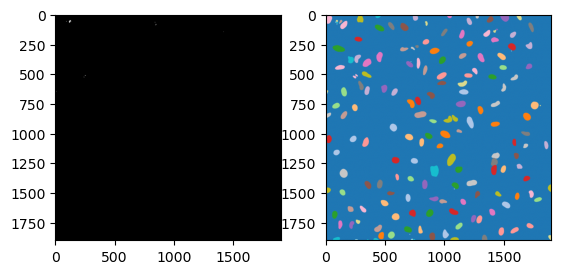

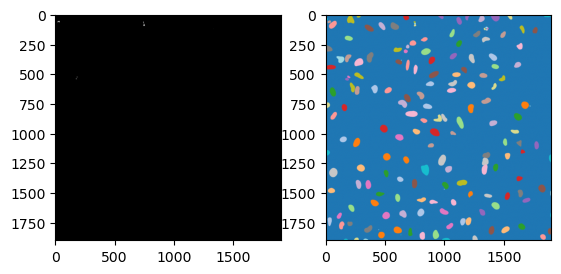

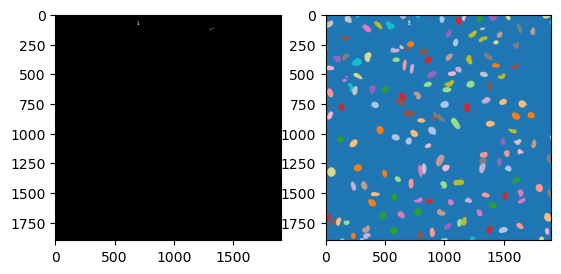

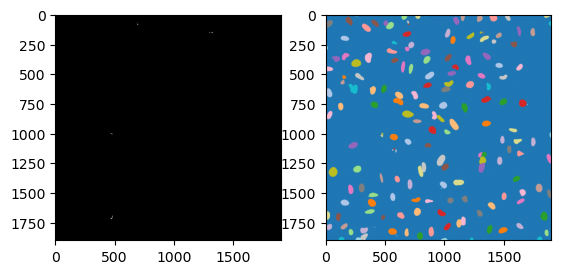

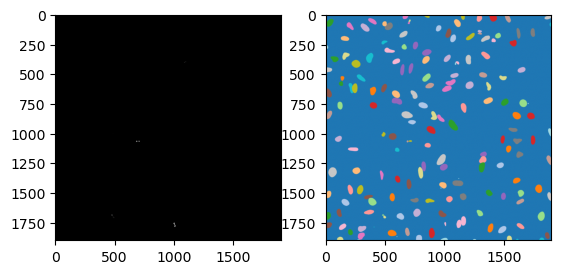

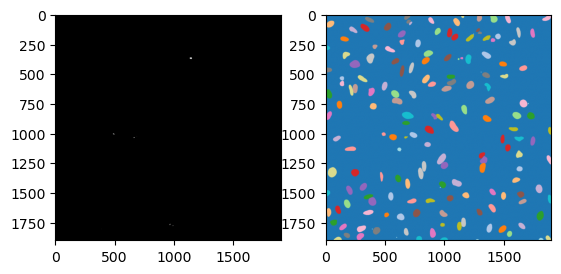

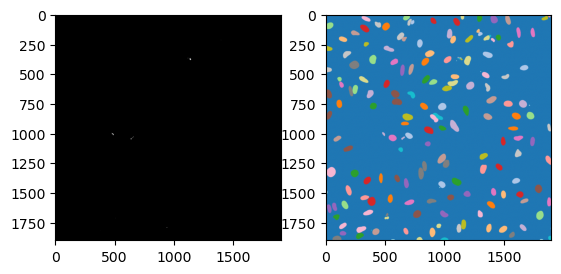

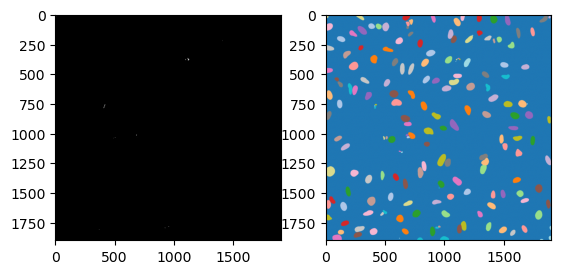

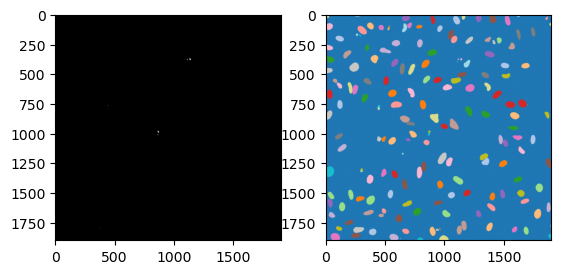

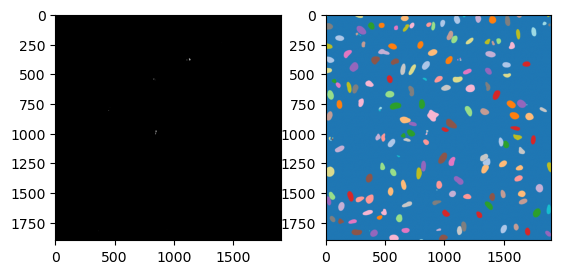

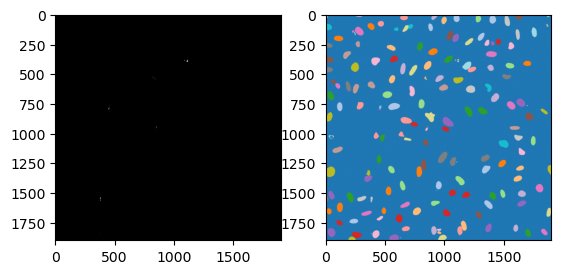

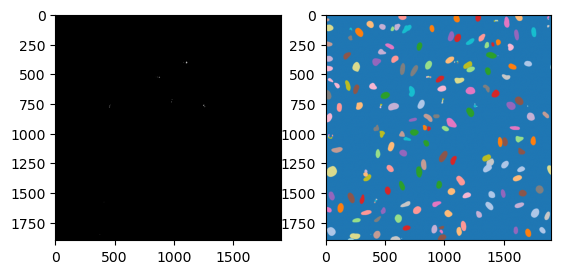

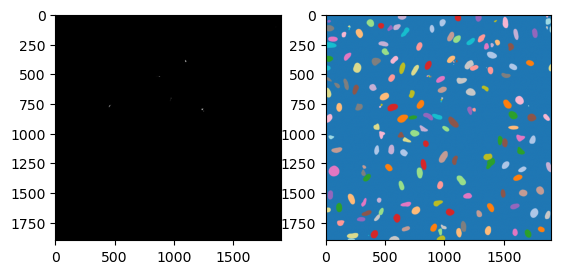

In [8]:
for i in range(0, stardist_labels.shape[0]):
    plt.subplot(1, 2, 1)
    plt.imshow(timelapse_raw[i, :, :], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(stardist_labels[i, :, :], cmap="tab20")
    plt.show()

In [9]:
detections = np.zeros(
    (len(files_dict["ch1"]), image_dims[0], image_dims[1]), dtype=np.uint16
)
edges = np.zeros(
    (len(files_dict["ch1"]), image_dims[0], image_dims[1]), dtype=np.uint16
)
for frame_index, frame in enumerate(stardist_labels):
    detections[frame_index, :, :], edges[frame_index, :, :] = labels_to_contours(frame)
print(detections.shape, edges.shape)
tifffile.imwrite("stardist_labels.tif", stardist_labels)
tifffile.imwrite("timelapse_raw.tif", timelapse_raw)
tifffile.imwrite("detections.tif", detections)
tifffile.imwrite("edges.tif", edges)

Converting labels to contours: 100%|██████████| 1900/1900 [00:00<00:00, 1929.54it/s]


(13, 1900, 1900) (13, 1900, 1900)


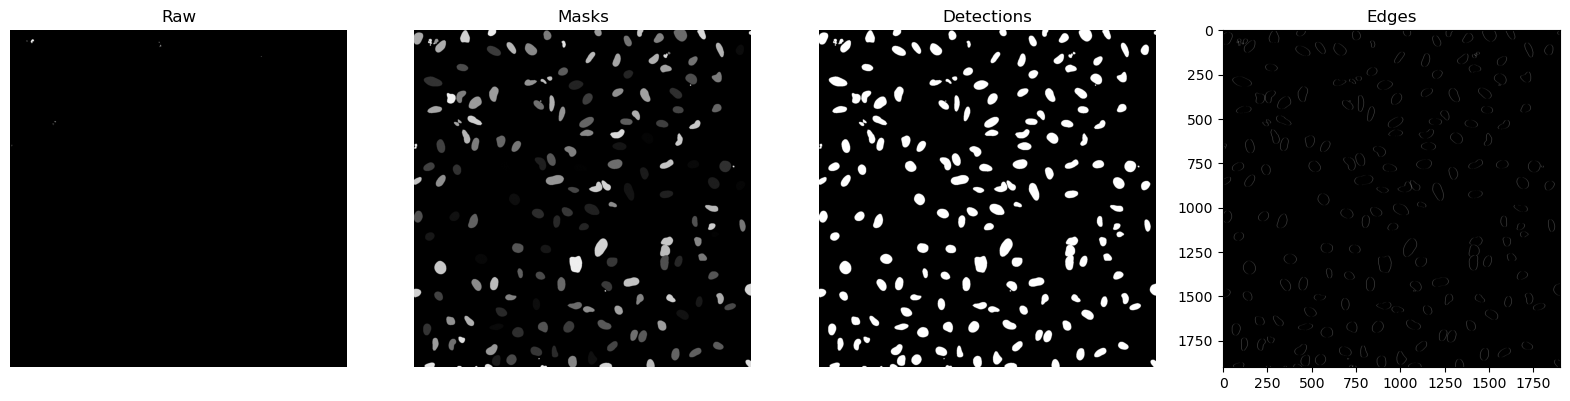

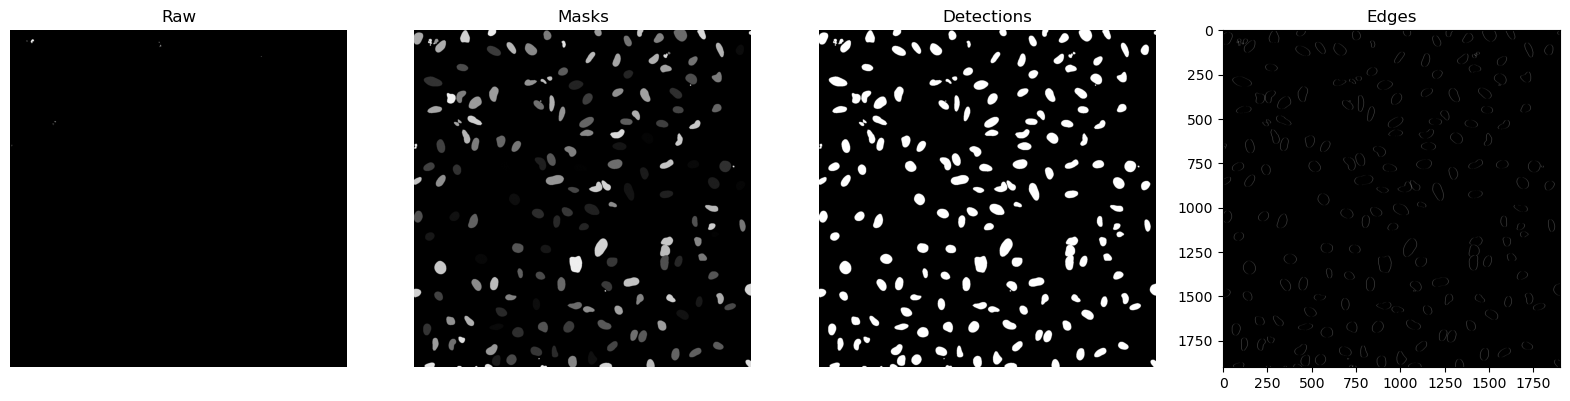

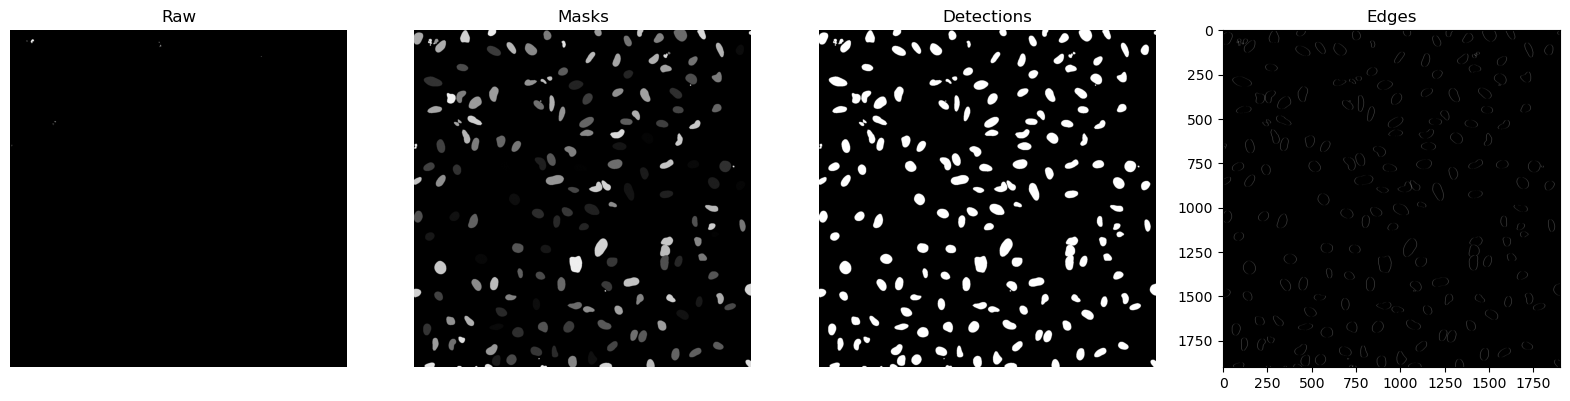

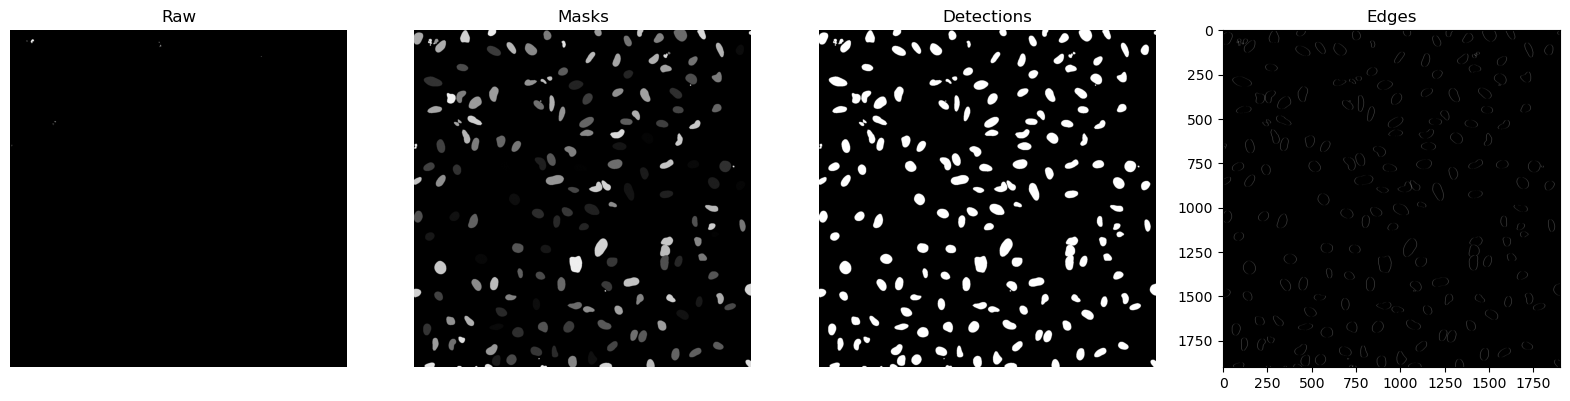

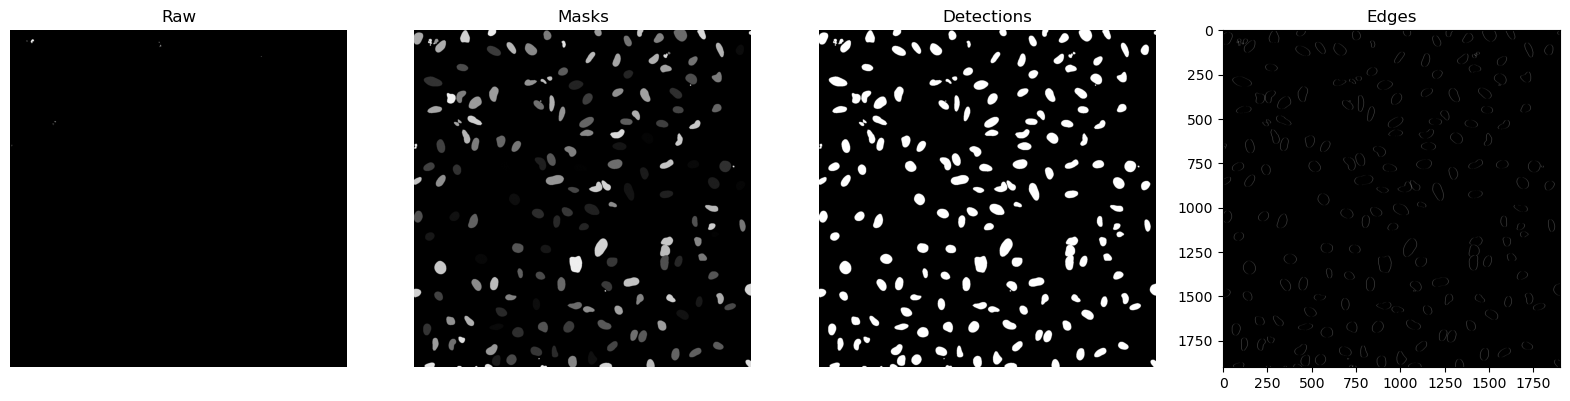

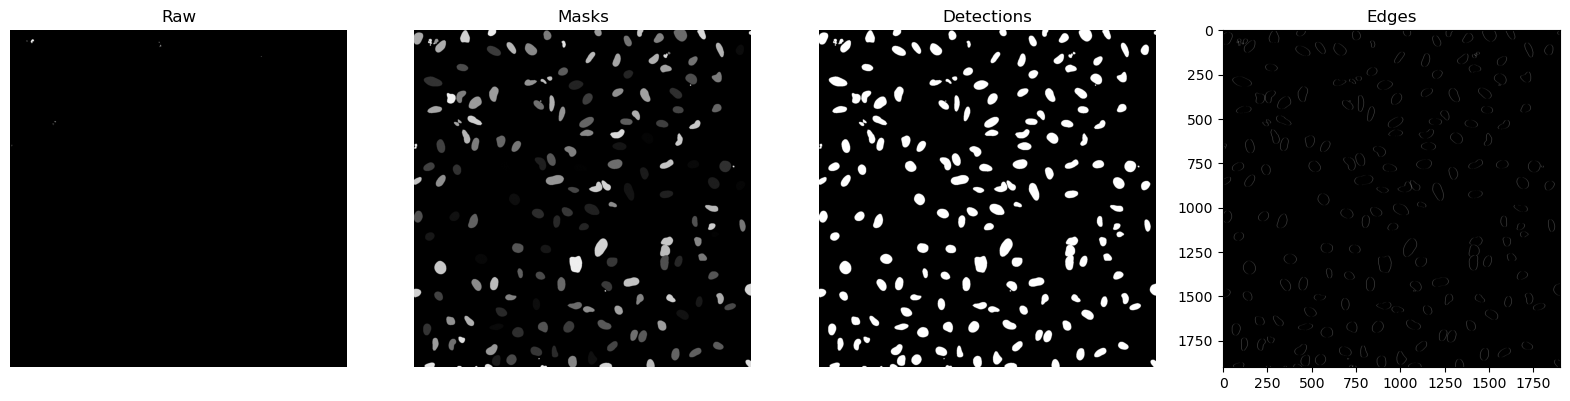

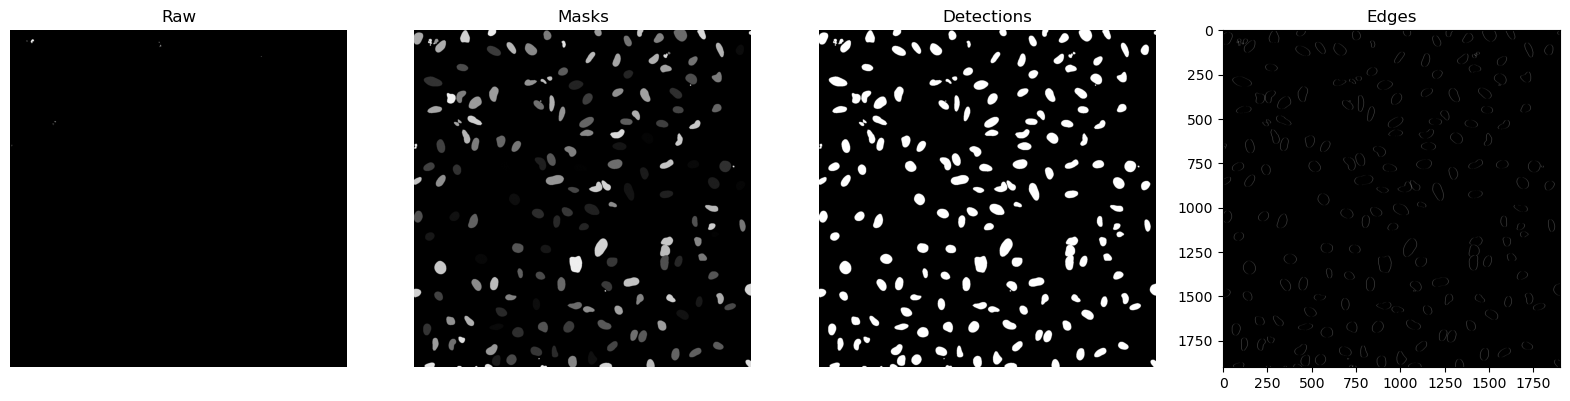

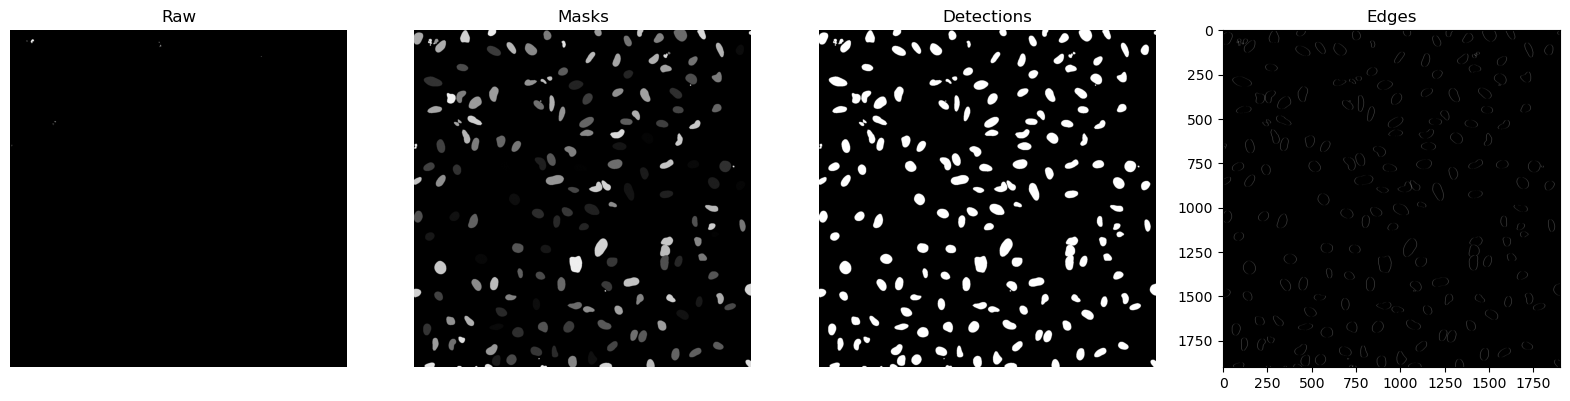

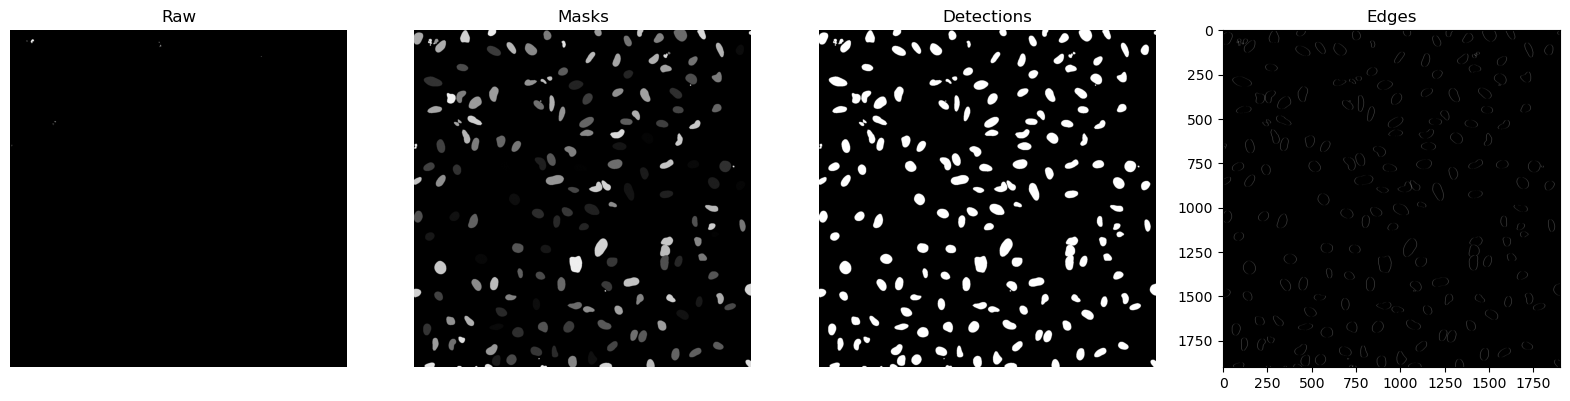

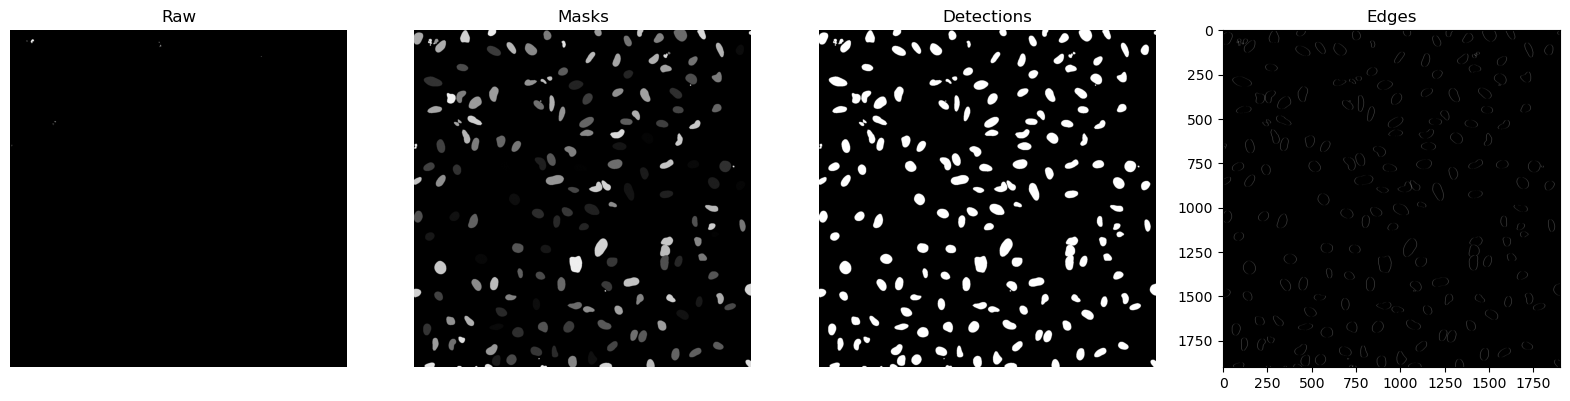

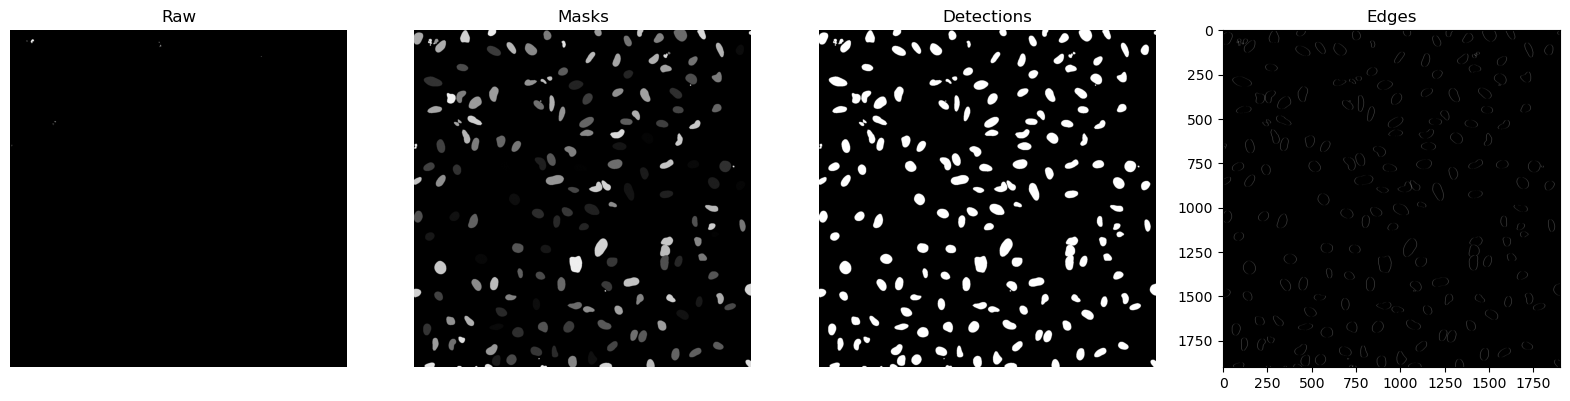

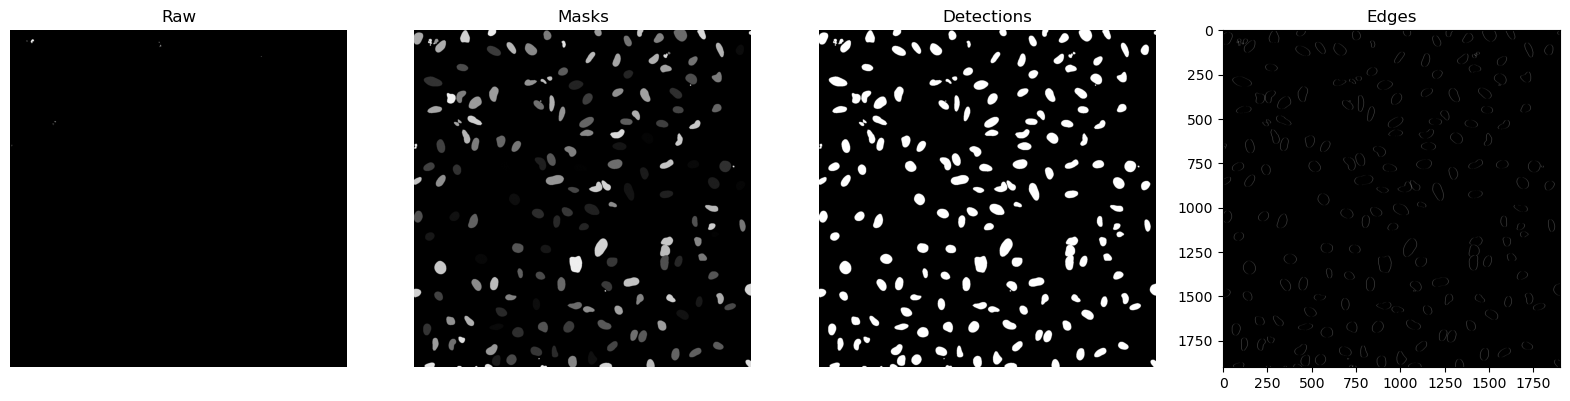

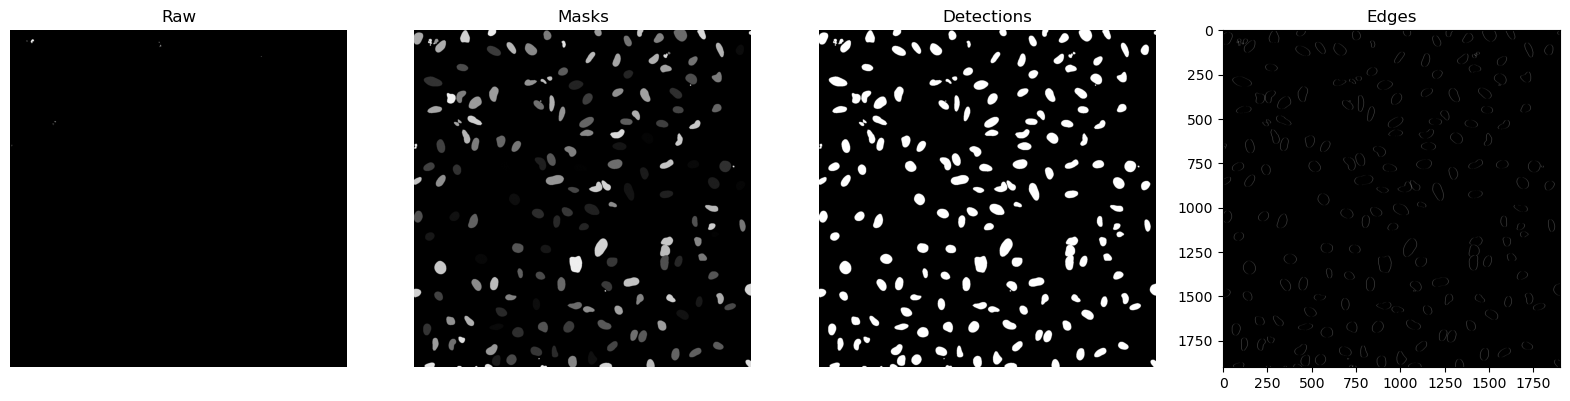

In [ ]:
if in_notebook:
    for frame_index, _ in enumerate(timelapse_raw):
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(timelapse_raw[frame_index, :, :], cmap="gray")
        plt.title("Raw")
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.imshow(stardist_labels[frame_index, :, :], cmap="gray")
        plt.title("Masks")
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.imshow(detections[frame_index, :, :], cmap="gray")
        plt.title("Detections")
        plt.axis("off")

        plt.subplot(1, 4, 4)
        plt.imshow(edges[frame_index, :, :], cmap="gray")
        plt.title("Edges")
        plt.show()

Estimating params.: 100%|██████████| 13/13 [00:00<00:00, 52.50it/s]


<Axes: title={'center': 'Area histogram'}, ylabel='Frequency'>

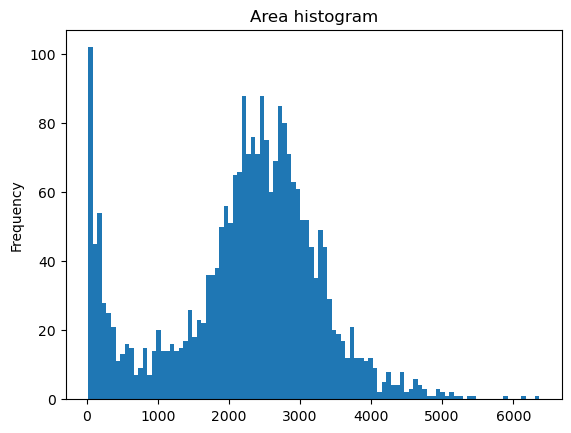

In [11]:
params_df = estimate_parameters_from_labels(stardist_labels, is_timelapse=True)
params_df["area"].plot(kind="hist", bins=100, title="Area histogram")

In [12]:
config = MainConfig()
config.segmentation_config.min_area = 50
config.segmentation_config.max_area = 950
config.segmentation_config.n_workers = 8
config.linking_config.max_distance = 25
config.linking_config.n_workers = 8

config.tracking_config.appear_weight = -1
config.tracking_config.disappear_weight = -1
config.tracking_config.division_weight = -0.1
config.tracking_config.power = 4
config.tracking_config.bias = -0.001
config.tracking_config.solution_gap = 0.0
config.tracking_config.solver_name = "CBC"
pprint(config)

MainConfig(
│   data_config=DataConfig(n_workers=1, working_dir=PosixPath('.'), database='sqlite', address=None),
│   segmentation_config=SegmentationConfig(
│   │   min_area=50,
│   │   max_area=950,
│   │   n_workers=8,
│   │   min_frontier=0.0,
│   │   threshold=0.5,
│   │   max_noise=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x7fd677f7b640>,
│   │   anisotropy_penalization=0.0
│   ),
│   linking_config=LinkingConfig(
│   │   max_distance=25,
│   │   n_workers=8,
│   │   max_neighbors=5,
│   │   distance_weight=0.0,
│   │   z_score_threshold=5.0
│   ),
│   tracking_config=TrackingConfig(
│   │   solver_name='CBC',
│   │   appear_weight=-1,
│   │   disappear_weight=-1,
│   │   division_weight=-0.1,
│   │   n_threads=-1,
│   │   window_size=None,
│   │   overlap_size=1,
│   │   solution_gap=0.0,
│   │   time_limit=36000,
│   │   method=0,
│   │   link_function='power',
│   │   power=4,
│   │   bias=-0.001,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None
│   )
)

In [13]:
track(
    foreground=detections,
    edges=edges,
    config=config,
    overwrite=True,
)

Linking nodes.: 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]


Using Coin-OR Branch and Cut solver
Solving ILP batch 0
Constructing ILP ...
Solving ILP ...
Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 4767 (-2417) rows, 8046 (-3141) columns and 14276 (-5876) elements
Clp1000I sum of infeasibilities 0.796039 - average 0.00016699, 3413 fixed columns
Coin0506I Presolve 1659 (-3108) rows, 1922 (-6124) columns and 5121 (-9155) elements
Clp0029I End of values pass after 1896 iterations
Clp0014I Perturbing problem by 0.001% of 0.99974611 - largest nonzero change 2.9972928e-05 ( 0.0014986464%) - largest zero change 2.983402e-05
Clp0000I Optimal - objective value 201.41335
Clp0000I Optimal - objective value 201.41335
Coin0511I After Postsolve, objective 201.41335, infeasibilities - dual 45.176721 (51), primal 0 (0)
Coin0512I Presolved model was optimal, full model needs cleaning up
Clp0014I Perturbing problem by 0.001% of 1 - 

In [14]:
tracks_df, graph = to_tracks_layer(config)
labels = tracks_to_zarr(config, tracks_df)
tracks_df.head()
tracks_df.to_parquet("tracks.parquet")

Exporting segmentation masks: 100%|██████████| 13/13 [00:00<00:00, 90.45it/s]


(2, 7)


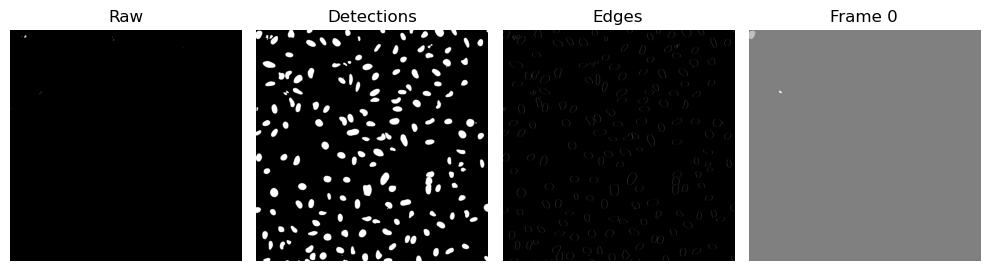

(43, 7)


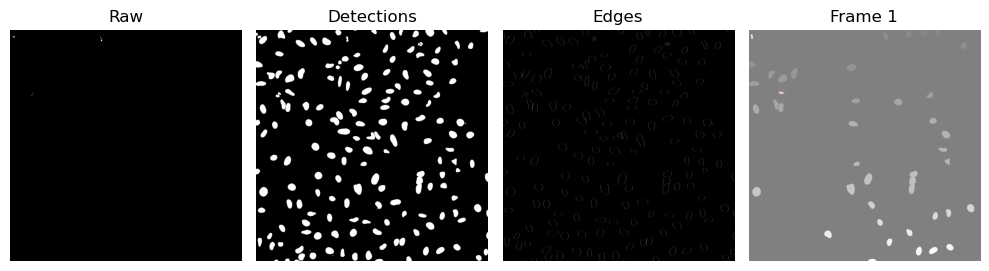

(118, 7)


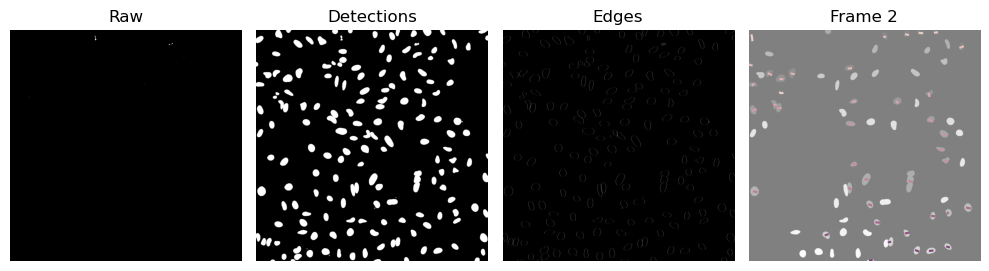

(196, 7)


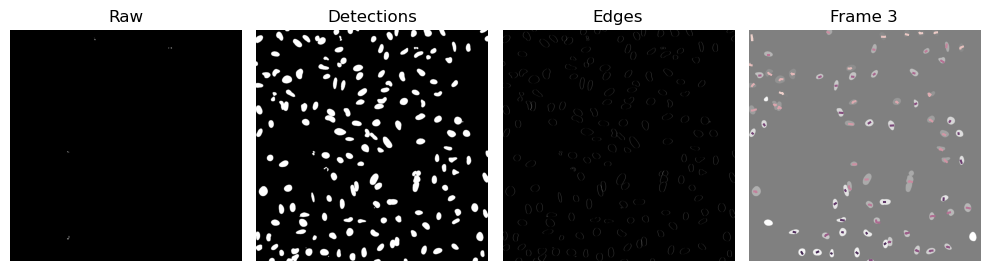

(277, 7)


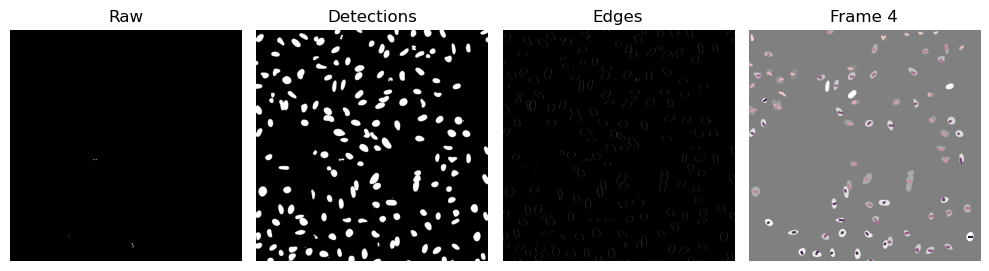

(360, 7)


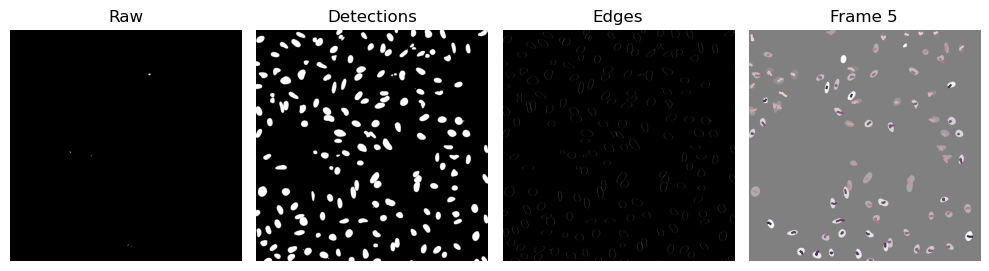

(445, 7)


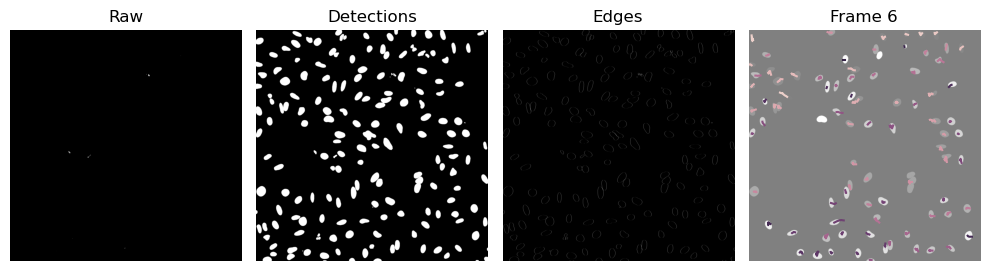

(531, 7)


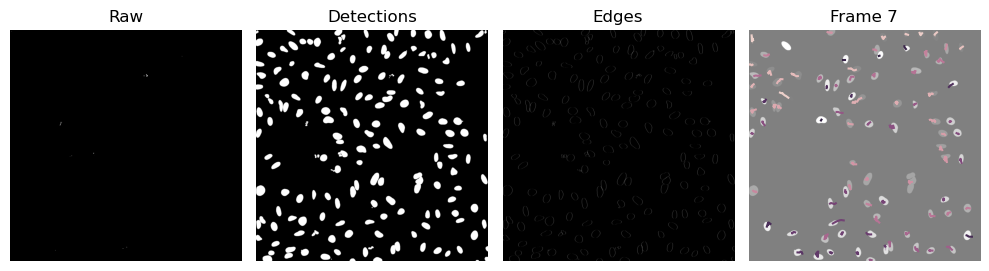

(620, 7)


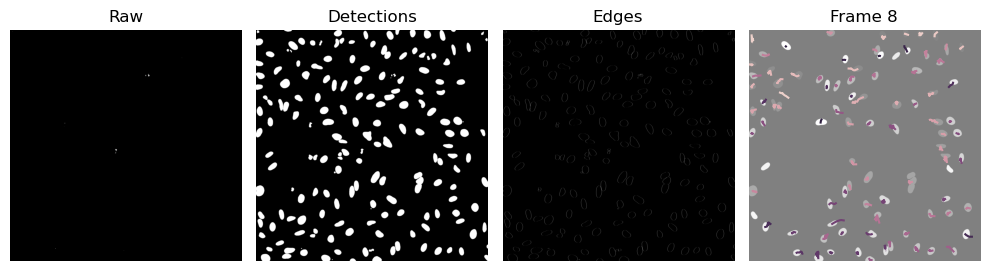

(709, 7)


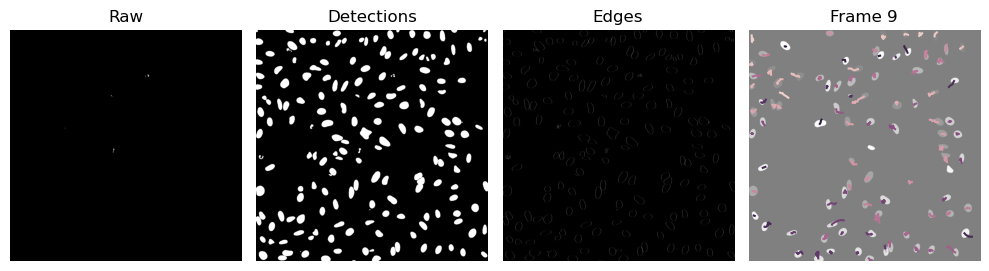

(798, 7)


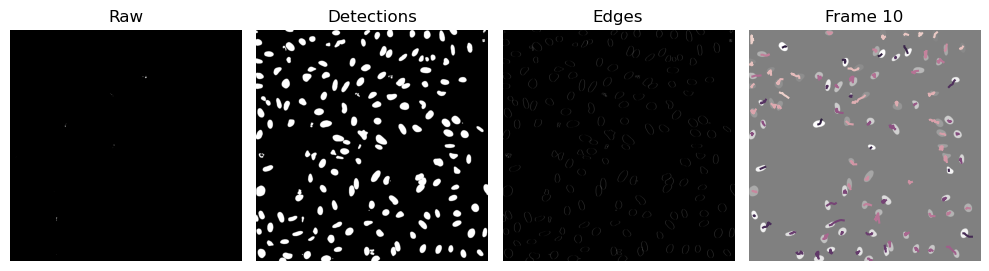

(886, 7)


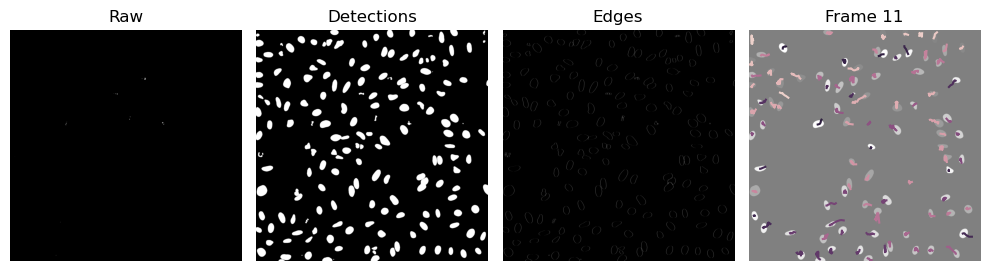

(972, 7)


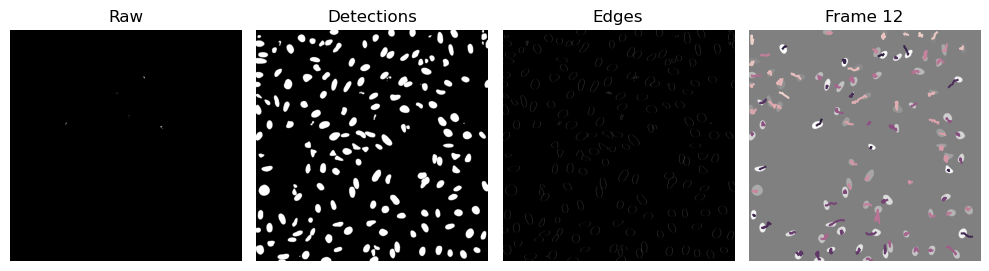

In [15]:
# save the tracks as parquet
tracks_df.reset_index(drop=True, inplace=True)
tracks = np.zeros(
    (len(files_dict["ch1"]), image_dims[0], image_dims[1]), dtype=np.uint16
)
cum_tracks_df = tracks_df.copy()
timepoints = tracks_df["t"].unique()

# zero out the track_df
cum_tracks_df = cum_tracks_df.loc[cum_tracks_df["t"] == -1]
cum_tracks_df
for frame_index in range(len(timepoints)):
    tmp_df = tracks_df[tracks_df["t"] == frame_index]
    cum_tracks_df = pd.concat([cum_tracks_df, tmp_df], ignore_index=True)
    print(cum_tracks_df.shape)
    # plot the tracks on the detections
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(timelapse_raw[frame_index, :, :], cmap="gray")
    plt.title("Raw")
    plt.axis("off")
    plt.subplot(1, 4, 2)
    plt.imshow(detections[frame_index, :, :], cmap="gray")
    plt.title("Detections")
    plt.axis("off")
    plt.subplot(1, 4, 3)
    plt.imshow(edges[frame_index, :, :], cmap="gray")
    plt.title("Edges")
    plt.axis("off")
    plt.subplot(1, 4, 4)
    sns.lineplot(data=cum_tracks_df, x="x", y="y", hue="track_id", legend=False)
    plt.imshow(labels[frame_index, :, :], cmap="gray", alpha=0.5)
    plt.title(f"Frame {frame_index}")
    plt.axis("off")
    plt.tight_layout()
    # add the plot to the tracks
    plt.savefig(f"tracks_{frame_index}.png")
    if in_notebook:
        plt.show()

In [16]:
# load each image
files = [f for f in Path().glob("tracks_*.png")]
files = sorted(files, key=lambda x: int(x.stem.split("_")[1]))
files
frames = [Image.open(f) for f in files]

In [17]:
fig_path = "tracks.gif"

In [18]:
# plot the line of each track in matplotlib over a gif
# get the tracks
# save the frames as a gif
frames[0].save(fig_path, save_all=True, append_images=frames[1:], duration=10, loop=0)